# Screen cropping of digital and digit detection

This notebook intends to first find the screens on the images, to make easier the digit detection. To do so we also make a rotation based on the screen crops to make it horizontal.

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

from google.colab.patches import cv2_imshow

Mounted at /content/drive


In [0]:
repo =  "/content/drive/My Drive/Team Bergere/Optimizer/Data/optimizer/HQ_digital/"

outs =  "/content/drive/My Drive/Team Bergere/Optimizer/Data/optimizer/HQ_digital/Cropped_Rotated/"

grey =  "/content/drive/My Drive/Team Bergere/Optimizer/Data/optimizer/HQ_digital/Greyscaled/"


In [0]:
# Packages
import cv2
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import math

### Define Functions to Crop the input image to retain only the screen

In [0]:
# Function to Develop Cropped Images

def screen_crop_images(img_inp):
    '''
    Function to crop the screens
        
        img_inp -- array with the image pixel values
    
    Returns the cropped screen
    '''
  
    # Adjustment Parameters
    exposure = float(3)
    blur = 5
    erode, erosion_iterations = 4, 3
    dilate, dilate_iterations = 4, 3

    # Copy into file
    image = img_inp.copy()

    # Greyscale Image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Inversion of colors
    image = 255-image

    # Blur to reduce noise
    image = cv2.GaussianBlur(image, (blur, blur), 0)

    # Dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate, dilate))
    image = cv2.dilate(image, kernel, iterations=dilate_iterations)

    # Contour Generation
    ret, threshold = cv2.threshold(image, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, contours, _ = cv2.findContours(threshold, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cv2.destroyAllWindows() 

    # Generate Cropped Image
    response = crop_to_screen_and_rotate(img_inp,contours)

    return response


# Function to crop given the Contours Round 1
def crop_to_screen_and_rotate(input_file,contour_boxed):
    """
    Function to take input file and screen contours, and return the rotated cropped screen based on angle in input image
    
    Input - Image input and contours generated by previous function
    
    Output - Cropped rotated Image
    
    """
    lims = list()
    area_piece = list()
    area_ratio = list()
    dim_ratios = list()
    x_lists = list()
    y_lists = list()
    total_area_in_shape = float(input_file.shape[1]*input_file.shape[0])
    pos_threshold = 0.3
    
    # Find dimensional metrics for each Contour
    for i in range(len(contour_boxed)):
        xdim = [x[0][0] for x in contour_boxed[i]]
        ydim = [x[0][1] for x in contour_boxed[i]]

        area_addit = (np.max(xdim)-np.min(xdim))*(np.max(ydim)-np.min(ydim))
        area_piece.append(area_addit)
        lims.append([min(xdim),min(ydim),max(xdim),max(ydim)])
        dim_ratios.append((max(xdim)-min(xdim))/(max(ydim)-min(ydim)))
        area_ratio.append(float(area_addit)/float(total_area_in_shape))
        x_lists.append(xdim)
        y_lists.append(ydim)
    
    # Create a DataFrame with all the metrics for all the contours
    restriction = pd.DataFrame()
    restriction['Areas'] = area_piece
    restriction['Ratio'] = area_ratio
    restriction['dim_ratio'] = dim_ratios
    restriction['xmax'] = [x[2] for x in lims]
    restriction['xmin'] = [x[0] for x in lims]
    restriction['ymax'] = [x[3] for x in lims]
    restriction['ymin'] = [x[1] for x in lims]

    restriction['xfull'] = x_lists
    restriction['yfull'] = y_lists

    restriction['xmean'] = (restriction['xmin']+restriction['xmax'])/2
    restriction['ymean'] = (restriction['ymin']+restriction['ymax'])/2
    
    # Check if the Position of the centroid of the contour box is near the center of the image
    restriction['x_pos_constr'] = restriction.xmean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[1]) and x<((0.5+pos_threshold)*input_file.shape[1])) else 0)
    restriction['y_pos_constr'] = restriction.ymean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[0]) and x<((0.5+pos_threshold)*input_file.shape[0])) else 0)

    # Apply conditions on the area, dimension ratios and position of centers to select the screen contour
    area_piece_res = list(restriction[(restriction['Ratio']<0.97)&(restriction['dim_ratio']<4.5)&(restriction['dim_ratio']>1)&(restriction['x_pos_constr']==1)&(restriction['y_pos_constr']==1)].Areas)
    req_contour = area_piece.index(sorted(area_piece_res)[-1])

    lims_fin = lims[req_contour]
    cropped = input_file[lims_fin[1]:lims_fin[3],lims_fin[0]:lims_fin[2]]
  
  
  
    # Rotation of the screen
    
    # Determine the border points of the contour
    res_temp = restriction.loc[req_contour]
    res_temp.yfull = [-x for x in res_temp.yfull]

    temp_df = pd.DataFrame()
    temp_df['x'] = res_temp.xfull
    temp_df['y'] = res_temp.yfull

    temp_df_u = temp_df.sort_values(by=['x','y'],ascending=[True,False]).drop_duplicates(subset=['x']).reset_index().drop('index',axis=1).rename(columns=({'y':'u_y'}))
    temp_df_d = temp_df.sort_values(by=['x','y'],ascending=[True,True]).drop_duplicates(subset=['x']).reset_index().drop('index',axis=1).rename(columns=({'y':'d_y'}))

    temp_max_x = temp_df[temp_df['x']==np.max(temp_df.x)]
    temp_min_x = temp_df[temp_df['x']==np.min(temp_df.x)]

    temp_max_y = temp_df[temp_df['y']==np.max(temp_df.y)]
    temp_min_y = temp_df[temp_df['y']==np.min(temp_df.y)]

    # Label the maximum of each X and Y points for corners
    max_x_pt = np.mean(temp_max_x.x),np.mean(temp_max_x.y)
    min_x_pt = np.mean(temp_min_x.x),np.mean(temp_min_x.y)
    max_y_pt = np.mean(temp_max_y.x),np.mean(temp_max_y.y)
    min_y_pt = np.mean(temp_min_y.x),np.mean(temp_min_y.y)

    dist_list = list()
    
    # Calculate the Angle of Rotation given the computed corner points
    
    angle = 0
    
    # Check if complete screen is in crop
    if (np.min(temp_df.x)==0 and (np.max(temp_min_x.y)-np.min(temp_min_x.y))>100) or (np.abs(np.max(temp_df.x)-input_file.shape[1])<2 and (np.max(temp_max_x.y)-np.min(temp_max_x.y))>100):
        angle = 0
    
    # If screen completely contained in crop then check if there are are 3 corner points or 4
    else:                    
        if distance_between(max_x_pt,min_y_pt)<100:
            max_x_pt=min_y_pt
        if distance_between(max_x_pt,max_y_pt)<100:
            max_x_pt=max_y_pt
        if distance_between(min_x_pt,min_y_pt)<100:
            min_x_pt=min_y_pt  
        if distance_between(min_x_pt,max_y_pt)<100:
            min_x_pt=max_y_pt

        pt_list = list((max_x_pt, min_x_pt, max_y_pt, min_y_pt))
    
    # If 3 corner points, then dont rotate. If 4 then rotate based on average of top and bottom lines of contour
    if len(list(dict.fromkeys(pt_list)))==4:
        sec_min_y = min_x_pt if min_x_pt[1]<max_x_pt[1] else max_x_pt
        sec_max_y = min_x_pt if min_x_pt[1]>max_x_pt[1] else max_x_pt
        angle = math.atan((((min_y_pt[1]-sec_min_y[1])/(min_y_pt[0]-sec_min_y[0]))+((max_y_pt[1]-sec_max_y[1])/(max_y_pt[0]-sec_max_y[0])))/2)

    h = cropped.shape[0]
    w = cropped.shape[1]
    
    # Use OpenCV to rotate image by defined angle
    center = (round(w/2),round(h/2))
    M = cv2.getRotationMatrix2D(center, -angle*180/math.pi, 1)
    rotated = cv2.warpAffine(cropped, M, (w, h))
    
    # Rotate if more than 5 degrees
    if np.abs(-angle*180/math.pi)<5:
        response = rotated
    else:
        response = screen_crop_images_rotated(rotated)
    return response

  
  


  
def screen_crop_images_rotated(img_inp):
    """
    Function to input rotated screen image and apply one additional crop post rotation to restrict to screen
    
    Input - Rotated Screen of image
    
    Output - Cropped rotated Image
    
    """
    # Adjustment Parameters
    exposure = float(3)
    blur = 5
    erode, erosion_iterations = 4, 3
    dilate, dilate_iterations = 4, 3

    # Copy into file
    image = img_inp

    # Blur to reduce noise
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.GaussianBlur(image, (blur, blur), 0)

    # Dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (dilate, dilate))
    image = cv2.dilate(image, kernel, iterations=dilate_iterations)

    # Contour Generation
    ret, threshold = cv2.threshold(image, 0,255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, contours, _ = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cv2.destroyAllWindows() 

    # Generate Cropped Image
    response = crop_to_screen(img_inp,contours)

    return response






# Function to crop given the Contours

def crop_to_screen(input_file,contour_boxed):
    """
    Utility function to Crop the Screen
    
    """
    lims = list()
    area_piece = list()
    area_ratio = list()
    dim_ratios = list()
    total_area_in_shape = float(input_file.shape[1]*input_file.shape[0])
    pos_threshold = 0.3
    
    # Find dimensional metrics for each Contour
    for i in range(len(contour_boxed)):
        xdim = [x[0][0] for x in contour_boxed[i]]
        ydim = [x[0][1] for x in contour_boxed[i]]

        area_addit = (np.max(xdim)-np.min(xdim))*(np.max(ydim)-np.min(ydim))
        area_piece.append(area_addit)
        lims.append([min(xdim),min(ydim),max(xdim),max(ydim)])
        dim_ratios.append((max(xdim)-min(xdim))/(max(ydim)-min(ydim)))
        area_ratio.append(float(area_addit)/float(total_area_in_shape))

    # Create a DataFrame with all the metrics for all the contours    
    restriction = pd.DataFrame()
    restriction['Areas'] = area_piece
    restriction['Ratio'] = area_ratio
    restriction['dim_ratio'] = dim_ratios
    restriction['xmax'] = [x[2] for x in lims]
    restriction['xmin'] = [x[0] for x in lims]
    restriction['ymax'] = [x[3] for x in lims]
    restriction['ymin'] = [x[1] for x in lims]

    restriction['xmean'] = (restriction['xmin']+restriction['xmax'])/2
    restriction['ymean'] = (restriction['ymin']+restriction['ymax'])/2
    
    # Check if the Position of the centroid of the contour box is near the center of the image
    restriction['x_pos_constr'] = restriction.xmean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[1]) and x<((0.5+pos_threshold)*input_file.shape[1])) else 0)
    restriction['y_pos_constr'] = restriction.ymean.apply(lambda x: 1 if (x>((0.5-pos_threshold)*input_file.shape[0]) and x<((0.5+pos_threshold)*input_file.shape[0])) else 0)

    
    # Apply conditions on the area, dimension ratios and position of centers to select the screen contour
    area_piece_res = list(restriction[(restriction['Ratio']<0.999)&(restriction['dim_ratio']<4.5)&(restriction['dim_ratio']>1)&(restriction['x_pos_constr']==1)&(restriction['y_pos_constr']==1)].Areas)

    try:
        req_contour = area_piece.index(sorted(area_piece_res)[-1])
    except:
        req_contour = area_piece.index(sorted(area_piece_res)[0])

    lims_fin = lims[req_contour]
    
    return input_file[lims_fin[1]:lims_fin[3],lims_fin[0]:lims_fin[2]]

### Run all the files in the High (or medium or low) quality image through the functions to generate screen cropped versions of all the images

In [0]:

total_files = len(os.listdir(repo))

for files in os.listdir(repo):
    if '.jpg' in files:
    
    # Load Images
    image = cv2.imread(repo+files)
    
    # Run Crop
    output = screen_crop_images(image)
    
    # Save into File
    Image.fromarray(output).save(outs+files[:-4]+'_cropped.jpg')


#### Example of Screen Crop Procedure

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


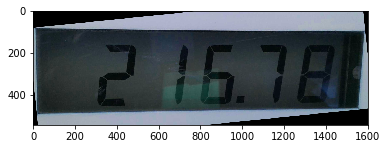

In [0]:
img_inp = cv2.imread(repo+'8e4f016190f77e5aa58c53509d869e915a0be67b.jpg')
output = screen_crop_images(img_inp)

imshow(output)


# Processing, post screen cropping

After cropping the screen and rotating, we have tried to find the contours of the digits. However, due to the low contrast of the numbers and the gray background, we did not reach to any interesting result. We present below the methods tried in any case.

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
# Support functions
def addContrast(image):
    '''
    Function to add contrast to the image, since many are very dark.
        image -- array of image pixel values
    Returns input image with greater contrast
    '''
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

  
  
# Function to Calculate optimal exposure for image contouring

def exposure_to_bright(file_in):
    """
    Function loads the images in a location and calculates the exposure to be applied to achieve a final center brightness of 120
    
    The function returns the optimal exposure and input image center brightnes
    
    Center brightness is defined as the pixel value average over the center of the image (within the screen) over 200x200 pixels
    """
    image = cv2.imread(file_in)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h1,w1 = image.shape
    h1 = round(h1/2)
    w1 = round(w1/2)

    i = 5
    flag = 0
    while ((i<101) and (flag==0)):
        exp = i/10
        image_t = cv2.multiply(image, np.array([exp]))

        out_mean = np.mean(image_t[h1-100:h1+100,w1-100:w1+100])

        if ((out_mean<125) and (out_mean>115)):
            flag = 1
        i = i+1

    return exp,np.mean(image[h1-100:h1+100,w1-100:w1+100])

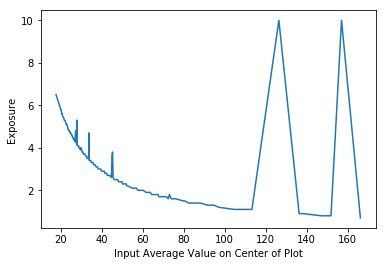

In [0]:
# Plot the distribution of the exposure vs input brightness

exposurein = list()
inp_bright = list()

data = 'Dataset/'
for f in os.listdir(data+'Cropped_Upd/'):
        a,b = exposure_to_bright(data+'Cropped_Upd/'+f)
        exposurein.append(a)
        inp_bright.append(b)
        
# Plot of Exposure vs Brightness
exposure_df = pd.DataFrame()
exposure_df['exp'] = exposurein
exposure_df['inp'] = inp_bright

exposure_df = exposure_df.sort_values(by=['inp','exp'])

plt.plot(exposure_df.inp,exposure_df.exp)
plt.ylabel('Exposure')
plt.xlabel('Input Average Value on Center of Plot')
plt.show()

[-1.46142540e-03  1.13148326e+02]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


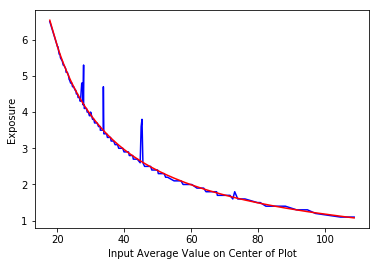

In [0]:
# Regression on the input brightness and the exposure to calculate the optimal exposure as a function of the brightness


lm = LinearRegression()

# retaining only till 110 to remove outliers

exposure_df_ret = exposure_df[exposure_df['inp']<110]

exposure_df_ret['inp_inv'] = 1/exposure_df['inp']

x = exposure_df_ret[['inp','inp_inv']].values
y = exposure_df_ret['exp'].values

lm.fit(x,y)

preds = lm.predict(x)

print(lm.coef_)

plt.plot(exposure_df_ret.inp,exposure_df_ret.exp, color='blue', label='Data')
plt.plot(exposure_df_ret.inp,preds, color='red', label='Predicted')
plt.ylabel('Exposure')
plt.xlabel('Input Average Value on Center of Plot')
plt.show()

Based on the regression shown above, the optimum exposure factor seem to be given by:

$$
    exposure = ax + \frac{b}{x}
$$

Where $a = -1.46142540e^{-3}$ and $1.13148326e^{2}$

Then, we can adjust the exposure of the image to improve it.

In [0]:
def extract_numbers(image): 
    '''
    Function to find the contours of digits
        image -- array with image pixel values
    Shows the original image with the contours found
    '''
    original = image.copy()
    sh = image.shape
    # Removing some borders since typically the border of the screens are really dark
    perc = 0.01
    image = image[int(sh[0]*perc):int(sh[0]*(1-perc)), int(sh[1]*perc):int(sh[1]*(1-perc))]
    
    # -----------Adjust Exposure--------
    # Exposure follows ax+b(1/x) formulation with params
    exposure_params = [-1.46142540e-03, 1.13148326e+02]
    # Dimensions
    h1,w1 = sh[0], sh[1]
    h1 = round(h1/2)
    w1 = round(w1/2)
    center_mean = np.mean(image[h1-100:h1+100,w1-100:w1+100])
    exposure = (exposure_params[0]*center_mean) + (exposure_params[1]/center_mean)

    image = cv2.multiply(image, np.array([exposure]))
    #imshow(image, cmap= "gray")
    
    #-----------Add Contrast------------
    
    image = addContrast(image)

    # --------------Convert to Greyscale -----------
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #imshow(image, cmap= "gray")
    
    # Adaptive Thresholding
    ad_threshold = 71
    ad_adjustment = 13
    image = cv2.adaptiveThreshold(image, 255, 
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,ad_threshold, ad_adjustment)
    #imshow(image, cmap= "gray")
    
    #----------BilateralFilter-----------
    diam = 10
    size = 80
    image = cv2.bilateralFilter ( image,diam , size, size )
    
    # ----------MORPHOLOGICAL TRANSFORM: Closing-------------
    close = 5
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (close, close))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    #imshow(image, cmap= "gray")
    
    # -------------------Erosion-----------------
    erode, er_it = 3,2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (erode, erode))
    image = cv2.erode(image, kernel, iterations=er_it)
    #imshow(image, cmap= "gray")
    
    def inverse_colors(img):
        img = (255 - img)
        return img

    # Reverse the image color
    #image = inverse_colors(image)
    #imshow(image, cmap= "gray")

    # Finding Contours
    contours,_= cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    for contour in contours:
        [x, y, w, h] = cv2.boundingRect(contour)
        if w*h > 800:
            original = cv2.rectangle(original, 
                    (int(x-0.01*w), int(y-h*0.01)), (int(x + 1.01*w), int(y + 1.01*h)), (255, 0, 0), 4)
    imshow(original, cmap= "gray")
    